## Probability ratio encoding

In the previous lectures in this section on how to engineer the labels of categorical variables, you learnt how to convert a label into a number, by using one hot encoding or replacing by frequency or counts. These methods are simple, make no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the risk (of the target)
- Replacing the labels by the joint probability of the target being 1 or 0
- Weight of evidence.

### Monotonicity

All these methods create a monotonic relationship between the categorical variable and the target. A monotonic relationship is a relationship that does one of the following: (1) as the value of one variable increases, so does the value of the other variable; or (2) as the value of one variable increases, the other variable value decreases. In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target decreases.

In general:

### Advantages

- Capture information within the label, therefore rendering more predictive features
- Creates a monotonic relationship between the variable and the target
- Does not expand the feature space

### Disadvantage

- Prone to cause over-fitting


### Note

The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".


### Replace labels by joint probability of the target being 1 or 0

For each label, we calculate the mean of target=1, that is the probability of being 1 ( P(1) ), and also the probability of the target=0 ( P(0) ). And then, we calculate the ratio P(1)/P(0), and replace the labels by that ratio.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# let's load again the titanic dataset

data = pd.read_csv('titanic.csv', usecols=['Cabin', 'Survived'])
data.head()

,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN


In [3]:
# let's first fill NA values with an additional label

data.Cabin.fillna('Missing', inplace=True)
data.head()

,Survived,Cabin
0,0,Missing
1,1,C85
2,1,Missing
3,1,C123
4,0,Missing


In [4]:
# Cabin has indeed a lot of labels, here for simplicity, I will capture the first letter of the cabin, 
# but the procedure could be done as well without any prior variable manipulation

len(data.Cabin.unique())

148

In [5]:
# Now we extract the first letter of the cabin

data['Cabin'] = data['Cabin'].astype(str).str[0]
data.head()

,Survived,Cabin
0,0,M
1,1,C
2,1,M
3,1,C
4,0,M


In [6]:
# check the labels
data.Cabin.unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

### Important

The calculation of the probability ratios to replace the labels should be done considering ONLY on the training set, and then expanded it to the test set.
See below.

In [7]:
# Let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data[['Cabin', 'Survived']],
                                                    data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 2), (268, 2))

In [8]:
# let's calculate the probability of Survived (target=1)
X_train.groupby(['Cabin'])['Survived'].mean()

Cabin
A    0.428571
B    0.774194
C    0.571429
D    0.692308
E    0.740741
F    0.666667
G    0.500000
M    0.303609
T    0.000000
Name: Survived, dtype: float64

In [9]:
# let's make a dataframe with the above

prob_df = X_train.groupby(['Cabin'])['Survived'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df

,Survived
Cabin,
A,0.428571
B,0.774194
C,0.571429
D,0.692308
E,0.740741
F,0.666667
G,0.500000
M,0.303609
T,0.000000


In [10]:
# now let's  calculate the probability of target = 0 (people who did not survive)
prob_df = X_train.groupby(['Cabin'])['Survived'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df['Died'] = 1-prob_df.Survived
prob_df

,Survived,Died
Cabin,,
A,0.428571,0.571429
B,0.774194,0.225806
C,0.571429,0.428571
D,0.692308,0.307692
E,0.740741,0.259259
F,0.666667,0.333333
G,0.500000,0.500000
M,0.303609,0.696391
T,0.000000,1.000000


In [11]:
#  and now the ratio

prob_df['ratio'] = prob_df.Survived/prob_df.Died
prob_df

,Survived,Died,ratio
Cabin,,,
A,0.428571,0.571429,0.750000
B,0.774194,0.225806,3.428571
C,0.571429,0.428571,1.333333
D,0.692308,0.307692,2.250000
E,0.740741,0.259259,2.857143
F,0.666667,0.333333,2.000000
G,0.500000,0.500000,1.000000
M,0.303609,0.696391,0.435976
T,0.000000,1.000000,0.000000


In [12]:
# let's make a dictionary with the above ratio

prob_df['ratio'].to_dict()

{'A': 0.75,
 'B': 3.4285714285714279,
 'C': 1.3333333333333333,
 'D': 2.25,
 'E': 2.8571428571428563,
 'F': 1.9999999999999998,
 'G': 1.0,
 'M': 0.4359756097560975,
 'T': 0.0}

In [13]:
ordered_labels = prob_df['ratio'].to_dict()

In [14]:
# replace the labels with the ratios

X_train['Cabin_ordered'] = X_train.Cabin.map(ordered_labels)
X_test['Cabin_ordered'] = X_test.Cabin.map(ordered_labels)

In [15]:
# check the results

X_train.head()

,Cabin,Survived,Cabin_ordered
857,E,1,2.857143
52,D,1,2.250000
386,M,0,0.435976
124,D,0,2.250000
578,M,0,0.435976


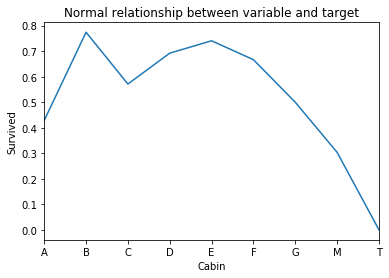

In [16]:
# plot the original variable

fig = plt.figure()
fig = X_train.groupby(['Cabin'])['Survived'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

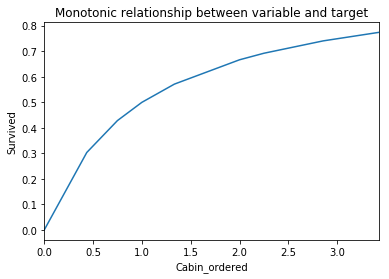

In [17]:
# plot the transformed result: the monotonic variable

fig = plt.figure()
fig = X_train.groupby(['Cabin_ordered'])['Survived'].mean().plot()
fig.set_title('Monotonic relationship between variable and target')
fig.set_ylabel('Survived')

As you can see in the above plot, there is now a monotonic relationship between the variable Cabin and probability of survival. The higher the Cabin number, the more likely the person was to survive.

### Note

Monotonic does not mean strictly linear. Monotonic means that it increases constantly, or it decreases constantly.